## Obliczanie parametrów pracy sprężarki chłodniczej dla dowolnego czynnika chłodniczego
Opracowanie: Bartosz Zajaczkowski ([bartosz.zajaczkowski@pwr.edu.pl](mailto:bartosz.zajaczkowski@pwr.edu.pl) )

Politechnika Wrocławska, Wydział Mechaniczno-Energetyczny
Katedra Termodynamiki, Teorii Maszyn i Urządzeń Cieplnych 

Wyb. Wyspiańskiego 27, 50-370 Wrocław, T: +48 71 320 3505, W: http://fluid.itcmp.pwr.edu.pl/~zajaczkowski

**Uaktualnione: 1.03.2018**

Przedstawiony poniżej algorytm umożliwia przeliczenie parametrów pracy sprężarki chłodniczej opisanej przez producenta dla określonego czynnika chłodniczego, na parametry pracy dla dowolnego innego czynnika. 

### Nomenklatura
* **referencyjny czynnik chłodniczy** - czynnik, dla którego producent opisał szczegółowe parametry pracy sprężarki (np. R22 lub R134a)
* **docelowy czynnik chłodniczy** - czynnik, który docelowo zostanie wykorzystany w instalacji chłodniczej - najczęściej będzie to jeden z nowych czynników, które mają zastąpić wycofane CFC, HCFC oraz wycofywane HFC.

### Procedura doboru sprężarki chłodniczej 
1. [Wstępne założenie parametrów pracy obiegu chłodniczego/pompy ciepła](#Wstępne-założenie-parametrów-pracy-obiegu-chłodniczego/pompy-ciepła)
2. [Identyfikacja obiegu chłodniczego dla docelowego czynnika chłodniczego](#Identyfikacja-obiegu-chłodniczego-dla-docelowego-czynnika-chłodniczego)
3. [Dobór sprężarki z katalogu producenta dla wskazanego referencyjnego czynnika chłodniczego](#Dobór-sprężarki-z-katalogu-producenta-dla-wskazanego-referencyjnego-czynnika-chłodniczego)
4. [Identyfikacja obiegu chłodniczego dla referencyjnego czynnika chłodniczego](#Identyfikacja-obiegu-chłodniczego-dla-referencyjnego-czynnika-chłodniczego)
5. [Sprawdzenie warunku sprężu](#Sprawdzenie-warunku-sprężu)
6. [Obliczenie sprawności izentropowej $n$ dla czynnika referencyjnego](#Obliczenie-sprawności-izentropowej-$n$-dla-czynnika-referencyjnego)
7. [Obliczenie stopnia dostarczania $\lambda$](#Obliczenie-stopnia-dostarczania-$\lambda$)
8. [Sprawdzenie warunku wydajności chłodniczej $Q_0$ sprężarki dla czynnika docelowego](#Sprawdzenie-warunku-wydajności-chłodniczej-$Q_0$-sprężarki-dla-czynnika-docelowego)
9. [Sprawdzenie warunku mocy sprężarki $L$ dla czynnika docelowego](#Sprawdzenie-warunku-mocy-sprężarki-$L$-dla-czynnika-docelowego)
10. [Wizualizacja obiegów na wykresie $\mathrm{log}\,p-h$](#Wizualizacja-obiegów-na-wykresie-$\mathrm{log}\,p-h$)

In [1]:
%pylab inline
import CoolProp.CoolProp as CP

Populating the interactive namespace from numpy and matplotlib


# Obliczenia obiegów i dobór sprężarki

### Wstępne założenie parametrów pracy obiegu chłodniczego/pompy ciepła
Sprężarkę zawsze dobiera się dla wstępnie znanych/zakładanych parametrów obiegu chłodniczego/pompy ciepła. 

Odpowiednio:
* wydajność chłodnicza $Q_0$
* temperatura parowania $T_0$
* temperatura skraplania $T_k$
* temperatura przegrzania $\Delta T_{sup}$

Wg EN-12900, w obliczeniu obiegu nie bierze się pod uwagę dochłodzenia.

In [2]:
# wydajność systemu chłodniczego
Q_0 = 12000 # [kW]

# temperatura wrzenia czynnika chłodniczego
T_0 = 0 + 273.15 # [K]

# założone przegrzanie par czynnika (efekt działania termostatycznego zaworu dławiącego, itp.)
dT_sup = 20 # [°C] - wg. EN 12900

#temperatura skraplania czynnika chłodniczego
T_k = 40 + 273.15 # [K]

### Identyfikacja referencyjnego obiegu chłodniczego (dla referencyjnego czynnika chłodniczego)
W pierwszej kolejności należy przeprowadzić identyfikację obiegu chłodniczego dla czynnika referencyjnego, w taki sam sposób jak czynnika docelowego. Celem jest ustalenie strumienia przepływu masy referencyjnego czynnika chłodniczego oraz wyznaczenie objętości właściwej par czynnika na wlocie do sprężarki.

Dla wyróżnienia, wszystkie parametry refencyjnego czynnika chłodniczego oznaczone są indeksem *ref*.

Katalogi udostępniane przez producentów sprężarek zwykle podają charakterystyki pracy urządzeń dla czynnika referencyjnego, np. **R22** lub **R134a**. Aby wykorzystać dane urządzenie z naszym docelowym czynnikiem chłodniczym, z  katalogu należy dobrać sprężarkę dla założonych parametrów pracy, ale dla referencyjnego czynnika chłodniczego, a następnie dokonać przeliczenia parametrów pracy dla czynnika docelowego.

In [3]:
# czynnik referencyjny do doboru sprężarki
refrigerant_ref = "R22"

Następnie wyznacza się ciśnienia pracy dla założonych temperatur parowania i skraplania, po czym oblicza się wartości entalpii w punktach charakterystycznych obiegu. Znajomość entalpii pozwala obliczyć właściwe ciepło parowania, skraplania oraz właściwą pracę sprężania. 

Ciepło właściwe parowania:
$$q_0 = h_1 - h_4$$
Ciepło właściwe skraplania:
$$q_k = h_2 - h_3$$
Właściwa praca obiegu:
$$l_{ob} = h_2 - h_1$$

W następnej kolejności można obliczyć strumień masy czynnika chłodniczego, teoretyczną wydajność cieplną skraplacza oraz teoretyczną moc sprężarki.

Strumień masy czynnika chłodniczego:
$$m_0 = \frac{Q_0}{q_0}$$

Teoretyczna wydajność cieplna skraplacza:
$$Q_k = m_0 \cdot q_k$$

Teoretyczna moc sprężarki:
$$L = m_0 \cdot l_{ob}$$

In [4]:
# ciśnienia pracy w obiegu referencyjnym
p_0_ref = CP.PropsSI('P','Q',1,'T',T_0,refrigerant_ref)
p_k_ref = CP.PropsSI('P','Q',1,'T',T_k,refrigerant_ref)

# wartości entalpii oraz entropii w punktach składających się na obieg referencyjny
if dT_sup > 0: h1_ref = CP.PropsSI('H','P',p_0_ref,'T',T_0+dT_sup,refrigerant_ref)
else: h1_ref = CP.PropsSI('H','Q',1,'T',T_0,refrigerant_ref)
s1_ref = CP.PropsSI('S','H',h1_ref,'P',p_0_ref,refrigerant_ref)
h2_ref = CP.PropsSI('H','S',s1_ref,'P',p_k_ref,refrigerant_ref)
h3_ref = CP.PropsSI('H','Q',0,'T',T_k,refrigerant_ref)
h4_ref = h3_ref

# właściwa wydajność chłodnicza parownika oraz praca sprężarki
q_0_ref = h1_ref - h4_ref
q_k_ref = h2_ref - h3_ref
l_ob_ref = h2_ref - h1_ref

# strumień masy czynnika referencyjnego dla znanej wydajności chłodniczej
m_0_ref = Q_0 / q_0_ref
print ("* Strumień masy czynnika chłodniczego: %.3f [kg/s]" % m_0_ref)

# objętość właściwa par czynnika referencyjnego na wlocie do sprężarki
v1_ref = 1 / CP.PropsSI('D','H',h1_ref,'P',p_0_ref,refrigerant_ref)
print ("* Objętość właściwa par czynnika referencyjnego na wlocie do sprężarki: %.3f [m3/kg]" % v1_ref)

* Strumień masy czynnika chłodniczego: 0.071 [kg/s]
* Objętość właściwa par czynnika referencyjnego na wlocie do sprężarki: 0.052 [m3/kg]


In [5]:
# strumień objętości pary czynnika referencyjnego przetłaczanej przez sprężarkę
V_sk_ref = (m_0_ref * v1_ref) * 3600
print ("* Strumień objętości pary przetłaczany przez sprężarkę: %.3f [m3/h]" % (V_sk_ref))

# właściwa objętościowa wydajność chłodnicza obliczona dla czynnika referencyjnego
q_v_ref = q_0_ref / v1_ref
print ("* Właściwa objętościowa wydajność chłodnicza: %.0f [J/m3]" % (q_v_ref))

* Strumień objętości pary przetłaczany przez sprężarkę: 13.219 [m3/h]
* Właściwa objętościowa wydajność chłodnicza: 3268038 [J/m3]


Teoretyczna wydajność ziębienia oraz moc sprężarki obliczone dla czynnika referencyjnego.

In [6]:
Q0_t_ref = V_sk_ref * q_v_ref / (3600)
print ("* Teoretyczna wydajność chłodnicza sprężarki: %.0f [W]" % (Q0_t_ref))

L_t_ref = m_0_ref * l_ob_ref
print ("* Teoretyczna moc sprężarki: %.0f [W]" % (L_t_ref))

* Teoretyczna wydajność chłodnicza sprężarki: 12000 [W]
* Teoretyczna moc sprężarki: 2188 [W]


### Dobór sprężarki dla wskazanego referencyjnego czynnika chłodniczego (z katalogu producenta)

Posługując się kartą katalogową lub programem komputerowym, należy ustalić wartości trzech parametrów pracy urządzenia. Parametrów które zostaną następnie wykorzystane do przeliczenia wydajności ziębniczej i mocy sprężarki na wartości osiągane przy zastosowaniu czynnika docelowego . Są to odpowiednio:
* **Pojemność skokowa** [m<sup>3</sup>/h] (teoretyczny strumień objętości pary przetłaczany przez sprężarkę.)
* **Wydajność ziębnicza** w założonym punkcie pracy [W]
* **Moc sprężarki** w założonym punkcie pracy [W]

Jeżeli w katalogu producenta nie ma podanej pojemności skokowej m<sup>3</sup>/h to trzeba ją wyliczyć. Należy odczytać w tym celu **pojemność cylindra** wyrażoną zwykle w cm<sup>3</sup> i przeliczyć ją na m<sup>3</sup> mnożąc razy 10<sup>-6</sup>/h. Następnie uzyskaną wartość **pomnożyć przez** podaną przez producenta **wartość obrotów silnika** (pamiętając o przeliczeniu ich z min<sup>-1</sup> na h<sup>-1</sup>).

In [7]:
# odczytana z katalogu pojemność skokowa
V_th = 16.73
print ("* Pojemność skokowa: %.3f [m3/h]" % (V_th))

# odczytana z katalogu rzeczywista wydajność sprężarki
Q0_rz_ref = 12555 # [W] - przykładowa wartość wprowadzona na podstawie katalogu
print ("* Wydajność ziębnicza: %.3f [W]" % (Q0_rz_ref)) 

# odczytana z katalogu rzeczywista moc sprężarki
L_rz_ref = 3794 # [W] -  przykładowa wartość wprowadzona na podstawie katalogu
print ("* Moc sprężarki: %.3f [W]" % (L_rz_ref)) 

* Pojemność skokowa: 16.730 [m3/h]
* Wydajność ziębnicza: 12555.000 [W]
* Moc sprężarki: 3794.000 [W]


### Identyfikacja obiegu chłodniczego dla docelowego czynnika chłodniczego

Przystępując do identyfikacji w pierwszej kolejności należy wskazać czynnik chłodniczy, który docelowo ma funkcjonować w projektowanym obiegu.

In [8]:
refrigerant = "R1234yf"

A następnie przeprowadzić obliczenia obiegu w sposób analogiczny jak dla czynnika referencyjnego.

In [9]:
# ciśnienia pracy w obiegu docelowym
p_0 = CP.PropsSI('P','Q',1,'T',T_0,refrigerant)
p_k = CP.PropsSI('P','Q',1,'T',T_k,refrigerant)

# wartości entalpii oraz entropii w punktach składających się na obieg docelowy
if dT_sup > 0: h1 = CP.PropsSI('H','P',p_0,'T',T_0+dT_sup,refrigerant)
else: h1 = CP.PropsSI('H','Q',1,'T',T_0,refrigerant)
s1 = CP.PropsSI('S','H',h1,'P',p_0,refrigerant)
h2 = CP.PropsSI('H','S',s1,'P',p_k,refrigerant)
h3 = CP.PropsSI('H','Q',0,'T',T_k,refrigerant)
h4 = h3

# właściwa wydajność chłodnicza parownika oraz praca sprężarki
q_0 = h1 - h4
q_k = h2 - h3
l_ob = h2 - h1

# strumień masy czynnika docelowego dla znanej wydajności chłodniczej (projektowanej)
m_0 = Q_0 / q_0
print ("* Strumień masy czynnika chłodniczego: %.3f [kg/s]" % m_0)

# objętość właściwa par czynnika docelowego na wlocie do sprężarki
v1 = 1 / CP.PropsSI('D','H',h1,'P',p_0,refrigerant)
v2 = 1 / CP.PropsSI('D','H',h2,'P',p_0,refrigerant)
print ("* Objętość właściwa par czynnika docelowego na wlocie do sprężarki: %.3f [m3/kg]" % v1)

* Strumień masy czynnika chłodniczego: 0.094 [kg/s]
* Objętość właściwa par czynnika docelowego na wlocie do sprężarki: 0.062 [m3/kg]


In [10]:
# strumień objętości pary czynnika docelowego przetłaczanej przez sprężarkę
V_sk = (m_0 * v1) * 3600
print ("* Strumień objętości pary przetłaczany przez sprężarkę: %.3f [m3/h]" % (V_sk))

# właściwa objętościowa wydajność chłodnicza obliczona dla czynnika docelowego
q_v = q_0_ref / v1_ref
print ("* Właściwa objętościowa wydajność chłodnicza: %.0f [J/m3]" % (q_v))

* Strumień objętości pary przetłaczany przez sprężarkę: 21.247 [m3/h]
* Właściwa objętościowa wydajność chłodnicza: 3268038 [J/m3]


Teoretyczna wydajność ziębienia oraz moc sprężarki obliczone dla czynnika docelowego.

In [11]:
Q0_t = V_th * q_v / (3600)
print ("* Teoretyczna wydajność chłodnicza sprężarki: %.0f [W]" % (Q0_t))

L_t = m_0 * l_ob
print ("* Teoretyczna moc sprężarki: %.0f [W]" % (L_t))

* Teoretyczna wydajność chłodnicza sprężarki: 15187 [W]
* Teoretyczna moc sprężarki: 2197 [W]


# Weryfikacja dobranej sprężarki dla czynnika docelowego

### Sprawdzenie warunku sprężu
Przed przystąpieniem do dalszych obliczeń należy przyjrzeć się jaki spręż jest niezbędny do realizacji sprężania obu analizowanych czynników. Generalnie stopień dostarczania sprężarki jest zależny (przede wszystkim) od wartości sprężu, dlatego należy sprawdzić czy dla analizowanych czynników wartości sprężu nie będą się znacząco od siebie nie różnić.
$$\Pi = \frac{p_0}{p_k}$$

Na potrzeby obliczeń projektowych powinno się przyjąć, że różnica nie powinna przekraczać kilku procent (nie jest to sztywna reguła). Jeśli różnica jest zbyt duża należy założyć, że konkretny rozpatrywany model sprężarki nie będzie sie nadawać do zastosowania z docelowym, planowanym w projekcie czynnikiem roboczym. Trzeba wtedy wybrać inny model sprężarki lub rozważyć zmianę czynnika.



In [12]:
print ("Stopień sprężania %s: %.3f" % (refrigerant_ref,p_k_ref/p_0_ref))
print ("Stopień sprężania %s: %.3f" % (refrigerant,p_k/p_0))

print ("Różnica: %.1f%%" % ((1-(p_k_ref/p_0_ref)/(p_k/p_0))*100))

Stopień sprężania R22: 3.080
Stopień sprężania R1234yf: 3.225
Różnica: 4.5%


### Obliczenie stopnia dostarczania $\lambda$

**Stopień dostarczania** (nazywany również współczynnikiem przetłaczania lub sprawnością objętościową sprężarki) jest to  stosunek ilościowy pary przetłaczanej przez sprężarkę $\dot{V_{sk}}$ do jej teoretycznej wydajności skokowej $\dot{V_{th}}$.

$$\lambda_{sp} = \frac{\dot{V_{sk}}}{\dot{V_{th}}}$$

Współczynnik ten odzwierciedla wszystkie straty występujące w sprężarce rzeczywistej.

$$\lambda_{sp} = \lambda_V \lambda_D \lambda_T \lambda_N$$

gdzie poszczególne składowe iloczynu to odpowiednio:

* $\lambda_V$ - **wskaźnik przestrzeni szkodliwej** (biorący pod uwagę wpływ wartości względnej przestrzeni szkodliwej, zastępczego wykładnika politropy rozprężania oraz wartości sprężu).
* $\lambda_D$ - **wskaźnik strat dławienia** w zaworach roboczych sprężarki [-]
* $\lambda_T$ - **wskaźnik oddziaływania termicznego ścian cylindrów**. W przybliżeniu $\lambda_T = T_0 / T_k$ [-]
* $\lambda_N$ - **wskaźnik strat nieszczelności** - przyjąć $\lambda_N = 0.98$ (wartość typowa dla nowych sprężarek to 0.99, dla sprężarek częściowo wyeksplowatowanych 0.95-0.98) [-]

Dla sprężarek napełnianych czynnikami syntetycznymi wartości stopnia dostarczania wahają sie w granicach od 0.6 do 0.9.

#### Obliczanie wskaźnika przestrzeni szkodliwej
Wskaźnik przestrzeni szkodliwej $\lambda_V$ oblicza się z zależności:

$$\lambda_V = 1 + C - C \cdot \left( \frac{p_k}{p_0} \right)^\frac{1}{\gamma}$$

Współczynnik przestrzeni szkodliwej $C$ jest to stosunek pojemności skokowej do objętości przestrzeni szkodliwej.

$$C = \frac{\dot{V_{sp}}}{\dot{V_{szk}}}$$

Jego wartość zwykle nie przekracza 0.05 i tyle należy przyjąć na potrzeby niniejszych obliczeń.

Wykładnik politropy dla sprężania izentropowego $\gamma$:

$$\gamma = \frac{c_p}{c_v}$$

#### Obliczanie wskaźnika oddziaływania termicznego
Przybliżoną wartość współczynnika oddziaływania termicznego można obliczyć na podstawie stosunku temperatur.
$$\lambda_T = \frac{T_0}{T_k}$$

In [13]:
# współczynnik przestrzeni szkodliwej
C = 0.05
# wykładnik politropy
γ = CP.PropsSI('C','H',h1,'P',p_0,refrigerant) / CP.PropsSI('O','H',h1,'P',p_0,refrigerant)
# wskaźnik przestrzeni szkodliwej
λ_V = 1 + C - C * pow(p_k/p_0,1/γ)
print ("* Wskaźnik przestrzeni szkodliwej λ_V: %.3f [-]" % (λ_V))

# wskaźnik strat dławienia
λ_D = 0.95
print ("* Wskaźnik strat dławienia λ_D: %.3f [-]" % (λ_D))

# wskaźnik oddziaływania termicznego
λ_T = T_0/T_k
print ("* Wskaźnik oddziaływania termicznego λ_T: %.3f [-]" % (λ_T))

# wskaźnik strat nieszczelności
λ_N = 0.99
print ("* Wskaźnik strat nieszczelności λ_N: %.3f [-]" % (λ_N))

* Wskaźnik przestrzeni szkodliwej λ_V: 0.909 [-]
* Wskaźnik strat dławienia λ_D: 0.950 [-]
* Wskaźnik oddziaływania termicznego λ_T: 0.872 [-]
* Wskaźnik strat nieszczelności λ_N: 0.990 [-]


In [14]:
λ_sp = λ_V * λ_D * λ_T * λ_N
print ("* Stopień dostarczania λ: %.3f [-]" % (λ_sp))

* Stopień dostarczania λ: 0.746 [-]


### Sprawdzenie warunku wydajności chłodniczej $Q_0$ sprężarki dla czynnika docelowego

Przyjmując założenie, że stopień dostarczania pozostaje taki sam bez względu na zastosowany czynnik (przy założeniu, że spręże dla obu czynników nie odbiegają od siebie zbytnio), można teraz obliczyć:
* strumień masy czynnika docelowego 
* wydajność ziębienia tej sprężarki przy zastosowaniu czynnika docelowego.

Jeżeli obliczona wydajność ziębienia **jest większa lub równa projektowanej**, oznacza to że sprężarka została dobrana prawidłowo.

In [17]:
# strumień masy czynnika docelowego przy założeniu, że stopień dostarczania pozostaje taki sam
# jak dla czynnika referencyjnego
m_0 = λ_sp * V_th / (3600 * v1)
print ("* Strumień masy czynnika docelowego przetłaczany przez sprężarkę: %.3f [kg/s]" % (m_0))

Q_0_sp = m_0 * q_0
print ("* Wydajność ziębienia przy docelowym czynniku: %.3f [kW]" % (Q_0_sp/1000))

L_sp = m_0 * l_ob
print ("* Moc sprężarki (teoretyczna): %.3f [kW]" % (L_sp/1000))
print ("* Moc sprężarki podana przez producenta: %.3f [W]" % (L_rz_ref))

* Strumień masy czynnika docelowego przetłaczany przez sprężarkę: 0.055 [kg/s]
* Wydajność ziębienia przy docelowym czynniku: 7.046 [kW]
* Moc sprężarki (teoretyczna): 1.290 [kW]
* Moc sprężarki podana przez producenta: 3794.000 [W]


### Obliczenie sprawności izentropowej $n$ i mocy sprężarki
Sprawność izentropową urządzenia oblicza się porównując teoretyczną moc sprężarki dla czynnika referencyjnego $L_{t,ref}$ do mocy podanej przez producenta dla zadanych warunków pracy dla czynnika referencyjnego $L_{rz,ref}$. Tak obliczona sprawność izentropowa zostanie potem wykorzystana do obliczenia parametrów pracy sprężarki po zastosowaniu czynnika docelowego.

In [16]:
n_sp = L_t_ref / L_rz_ref
print ("* Współczynnik sprawności izentropowej n: %.3f [-]" % (n_sp)) 
print ("* Moc sprężarki (po uwzględnieniu sprawności izentropowej): %.3f [W]" % (L_sp/n_sp))

* Współczynnik sprawności izentropowej n: 0.577 [-]
* Moc sprężarki (po uwzględnieniu sprawności izentropowej): 2236.354 [W]


### Sprawdzenie czy silnik sprężarki posiada wystarczającą moc $L$ dla czynnika docelowego

Na sam koniec należy sprawdzić moc podana przez producenta (dla czynnika referencyjnego i danego punktu pracy) **jest większa niż moc wyliczona dla nowego czynnika przy uwzględnieniu sprawności izentropowej *n***. Jak ten warunek nie jest spełniony to sprężarka może mieć ma za słaby napęd, aby poradzić sobie z nowym czynnikiem (w danym punktcie pracy).

In [18]:
if (L_sp/n_sp) < L_rz_ref: print ("DOBRZE! Sprężarka wygląda na dobraną prawidłowo!")
else: print ("ŻLE! Sprężarka dobrana nieprawidłowo!")

DOBRZE! Sprężarka wygląda na dobraną prawidłowo!


### Wizualizacja obiegów na wykresie $\mathrm{log}\,p-h$

W pierwszej kolejności należy obliczyć wartość entalpii na końcu procesu sprężania z uwzględnieniem sprawności izentropowej $n$, proporcjonalnie za pomocą wrozu:

$$h_{2^\prime} = h_1 + \frac{h_2 - h_1}{n}$$

Obliczenie korekcyjne wykonuje się dla położenia punktu 2 na wykresie dla czynnika docelowego oraz referencyjnego użytego do doboru sprężakrki.

In [19]:
# czynnik docelowy
h2b = h1 + (h2 - h1) / n_sp

# czynnik referencyjny
h2b_ref = h1_ref + (h2_ref - h1_ref) / n_sp

Wyznaczenie linii nasycenia cieczy i pary obu czynników.

In [20]:
steps = 60
pres = ones(steps)
satl = zeros(steps)
satv = zeros(steps)
pres_ref = ones(steps)
satl_ref = zeros(steps)
satv_ref = zeros(steps)

p_min = p_0 - 50000
p_crit = CP.PropsSI(refrigerant,'pcrit')
p_step = (p_crit - p_min)/(steps-1)

for i in range(0,steps):
    pres[i] = p_min + i * p_step
    satl[i] = CP.PropsSI('H','Q',0,'P',pres[i],refrigerant)
    satv[i] = CP.PropsSI('H','Q',1,'P',pres[i],refrigerant)

print ("* Ciśnienie krytyczne %s: %.0f [Pa]" % (refrigerant, p_crit))

p_min_ref = p_0 - 50000
p_crit_ref = CP.PropsSI(refrigerant_ref,'pcrit')
p_step_ref = (p_crit_ref - p_min_ref)/(steps-1)

for i in range(0,steps):
    pres_ref[i] = p_min_ref + i * p_step_ref
    satl_ref[i] = CP.PropsSI('H','Q',0,'P',pres_ref[i],refrigerant_ref)
    satv_ref[i] = CP.PropsSI('H','Q',1,'P',pres_ref[i],refrigerant_ref)

print ("* Ciśnienie krytyczne %s: %.0f [Pa]" % (refrigerant_ref, p_crit_ref))

* Ciśnienie krytyczne R1234yf: 3382200 [Pa]
* Ciśnienie krytyczne R22: 4990000 [Pa]


#### Wykres porównawczy obu obiegów

Text(0,0.5,'Cisnienie [Pa]')

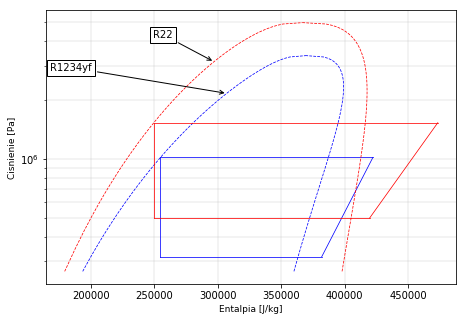

In [21]:
# plot results
plt.figure()

# grid and axes
plt.axes([0.025, 0.025, 0.95, 0.95])
plt.grid(which='major', axis='x', linewidth=0.25, linestyle='-', color='0.65')
plt.grid(which='minor', axis='x', linewidth=0.25, linestyle='-', color='0.65')
plt.grid(which='major', axis='y', linewidth=0.25, linestyle='-', color='0.65')
plt.grid(which='minor', axis='y', linewidth=0.25, linestyle='-', color='0.65')

# data
plt.plot([h4,h1], [p_0,p_0], 'b-', linewidth=0.75)
plt.plot([h1,h2b], [p_0,p_k], 'b-', linewidth=0.75)
plt.plot([h2b,h3], [p_k,p_k], 'b-', linewidth=0.75)
plt.plot([h3,h4], [p_k,p_0], 'b-', linewidth=0.75)

plt.semilogy(satl, pres, 'b--', linewidth=0.75)
plt.semilogy(satv, pres, 'b--', linewidth=0.75)

# data (ref)
plt.plot([h4_ref,h1_ref], [p_0_ref,p_0_ref], 'r-', linewidth=0.75)
plt.plot([h1_ref,h2b_ref], [p_0_ref,p_k_ref], 'r-', linewidth=0.75)
plt.plot([h2b_ref,h3_ref], [p_k_ref,p_k_ref], 'r-', linewidth=0.75)
plt.plot([h3_ref,h4_ref], [p_k_ref,p_0_ref], 'r-', linewidth=0.75)

plt.semilogy(satl_ref, pres_ref, 'r--', linewidth=0.75)
plt.semilogy(satv_ref, pres_ref, 'r--', linewidth=0.75)


# opis punktów

plt.annotate(refrigerant, 
             xy=(satl[round(0.6 * steps)],pres[round(0.6 * steps)]), xytext=(satl[round(0.9 * steps)]-160000,pres[round(0.9 * steps)]), bbox=dict(boxstyle="square", fc="w"),
             arrowprops=dict(facecolor='red', arrowstyle="->"), horizontalalignment='center', 
             verticalalignment='top', fontsize=10)
plt.annotate(refrigerant_ref, 
             xy=(satl_ref[round(0.6 * steps)],pres_ref[round(0.6 * steps)]), xytext=(satl_ref[round(0.9 * steps)]-80000,pres_ref[round(0.9 * steps)]), bbox=dict(boxstyle="square", fc="w"),
             arrowprops=dict(facecolor='red', arrowstyle="->"), horizontalalignment='center', 
             verticalalignment='top', fontsize=10)

plt.xlabel('Entalpia [J/kg]',fontsize=9)
plt.ylabel('Cisnienie [Pa]',fontsize=9)